# BIOS 8366 Final Project 

Bob Chen, <bob.chen@vanderbilt.edu> (worked alone)

The dataset(s) used for the analyses described were obtained from Vanderbilt University Medical Center’s Synthetic Derivative which is supported by institutional funding and by the Vanderbilt CTSA grant ULTR000445 from NCATS/NIH

# Modeling

## Import packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import explained_variance_score,confusion_matrix
from sklearn import svm,model_selection,preprocessing
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

## Load preprocessed data and scale it

After loading the data into memory, we had to separate the target and predictor variables as well as indicate which of the columns should be the index, the RUID.

In [11]:
dataIn=pd.read_csv("Encoded_QC_Data_V3.csv")

In [12]:
dataIn.index=dataIn.pop('RUID')

In [13]:
readmit=dataIn.pop('Threshold Readmit')

Before any sort of model is built, I scaled the data using the RobustScaler, this was done because several of the features are on entirely different scales. For example, BMI values were usually between 10 and 40, whereas the number of measurements taken for BMI would be far greater. Thus, I opted to scale the values of each column with respect to itself. This reduced some of the bias that could have existed for inherently variable or high value features.  

In [20]:
rs_transformer = RobustScaler().fit(dataIn)
rs_transformed=rs_transformer.transform(dataIn)
rs_df=pd.DataFrame(rs_transformed)
rs_df.columns=dataIn.columns
rs_df.index=dataIn.index
dataIn=rs_df
dataIn.head()

,Female,Male,BMI Count,Mean BMI,BMI std,Min BMI,25% BMI,Med BMI,75% BMI,Max BMI,...,Med_Code_zofran,Med_Code_zoloft,Med_Code_zolpidem,Med_Code_zometa,Med_Code_zonisamide,Med_Code_zyprexa,Med_Code_zyrtec,DoB,MoB,YoB
RUID,,,,,,,,,,,,,,,,,,,,,
50135262,0.0,0.0,0.938776,1.709327,1.566829,1.470357,-0.276394,1.766532,1.778802,1.729090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.266667,0.333333,-0.342857
50135361,-1.0,1.0,2.346939,0.475002,0.978970,0.902344,-1.081851,0.261269,0.567844,0.585739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.066667,-0.833333,-0.828571
50135369,-1.0,1.0,1.795918,-0.050978,-0.286544,-0.320446,-0.454330,-0.004588,-0.033794,-0.066864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.800000,-0.333333,-0.085714
50135375,-1.0,1.0,3.306122,-0.007740,0.102938,0.055887,0.088968,-0.073144,0.010241,-0.019245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,-0.333333,-0.514286
50135425,0.0,0.0,1.428571,0.633938,1.221556,1.136740,0.661922,0.485560,0.518177,0.600049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.933333,0.500000,-0.428571


## Data partitioning, Model building, and rationale

In total I tried three strategies with respect to the type of available data in the preprocessed dataset. With these data partitioning strategies, I then applied three different modeling strategies to each one of them. 

__My goal with these strategies was to train a model that could predict, if given some features, whether or not a patient has experienced a readmission event within 30 days of being discharged, generally.__

__In total I tried 9 combinations of different partitions of data to use and modeling methods. Interpretation of the accuracy scores and future directions in analysis is included at the end of this notebook.__

__Data partitioning strategy 1, No coded categorical features:__ Due to how I one-hot encoded the coded categorical values present in the CPT, ICD9, LAB, and MED the resulting one-hot encoded features became very sparse. Which can be concerning due to the curse of dimensionality. I reasoned that perhaps the features with the continuous variables would be more informative in the end. Therefore, this partitioning was designed to observe the predictive power of just the continuous variables (like BMI, EGFR, etc.) since they were more information-dense than the one-hot encoded features.

__Data partitioning strategy 2, Only coded categorical features:__ It was also possible that the coded features contained the most vital information, as in a way, the coding with some procedure, ICD9 code, etc. was a value designated by integrating all available information at the time. This is meant in the sense that a human medical professional integrated all of the biometric information, lab tests, and previous records, and then used all of this to make a classification to code the patient. Although sparse, it was interesting to see how our three modeling strategies would perform.

__Data partitioning strategy 3, All features available__ : This was simply the "throw in as many features as possible" strategy. The incorporation of the dense, continuous features in combination with the sparse, one-hot encoded variables could possibly be the most informative combination of predictor variables. It would take the advantages (and disadvantages) of both partitions of the full dataset for model building. This was the slowest partitioning strategy to train with the models, likely due to the variety and increased number of features. 

__Modeling strategy 1, Logistic regression + CV:__ This was the simplest and fastest modeling strategy, there were few parameters to optimize.

__Modeling strategy 2, Radial basis function support vector classifier + GridsearchCV:__ This was the slowest modeling strategy, but it's performance has been reasonable in the past and there were relatively few hyperparameters to optimize compared to random forests.  

__Modeling strategy 3, Random forest classifier + GridsearchCV:__ This was a balanced modeling strategy, it's performance has been very good in the past and there are a good amount of hyperparameters to tune using gridsearch which can be completed relatively quickly. It also comes with the advantage that I could visualize the best performing classifier, which allows for an intuitive interpretation of the models.





## First strategy: No coded categorical values

__Logistic regression__

Started by removing the non_categorical_columns and splitting up the data into training and testing sets, doing 5-fold cross-validation, with surprisingly accurate results. 

In [17]:
non_categorical_columns=['Female','Male','BMI Count','Mean BMI','BMI std','Min BMI','25% BMI','Med BMI','75% BMI','Max BMI','Mean Weight','Weight std','Min Weight',
 '25% Weight','Med Weight','75% Weight','Max Weight','Mean Height','Height std','Min Height','25% Height','Med Height','75% Height','Max Height','Pregnancy','BP Count',
 'Mean Systolic','Systolic std','Min Systolic','25% Systolic','Med Systolic','75% Systolic','Max Systolic','Mean Diastolic','Diastolic std','Min Diastolic','25% Diastolic',
 'Med Diastolic','75% Diastolic','Max Diastolic','S/D Ratio','EGFR Count','Mean EGFR','EGFR std','Min EGFR','25% EGFR','Med EGFR','75% EGFR','Max EGFR','Top_CPT_Count','Unique_CPTs',
 'Total_CPT_Count','Top_ICD9_Count','Unique_ICD9s','Total_ICD9_Count','Top_Lab_Count','Unique_Labs','Total_Lab_Count','Top_Med_Count','Unique_Meds','Total_Med_Count','DoB', 'MoB', 'YoB']

In [21]:
data_1=dataIn[non_categorical_columns]

In [24]:
X_train_1, X_test_1, y_train_1, y_test_1 = model_selection.train_test_split(data_1, readmit, test_size=0.2, random_state=0)

In [25]:
logreg_1 = LogisticRegression(solver='lbfgs',max_iter=20000,n_jobs=8)

In [26]:
scores_log_reg_1 = model_selection.cross_val_score(logreg_1, X_train_1, y_train_1, cv=5)
scores_log_reg_1

array([0.73828125, 0.74609375, 0.75749674, 0.75880052, 0.75880052])

In [27]:
logreg_1.fit(X_train_1,y_train_1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=20000, multi_class='warn',
          n_jobs=8, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [120]:
pred_1_log=logreg_1.predict(X_test_1)

In [122]:
logreg_1_score=logreg_1.score(X_test_1, y_test_1)

In [121]:
logreg_1_confusion=confusion_matrix(y_test_1, pred_1_log)

__Support Vector Classifier__

Started with an arbitrary gamma for the SVC, tried 5-fold cross-validation to unimpressive accuracy scores. Then optimized gamma using GridSearchCV, with underwhelming results.

In [149]:
svc_rbf_1 = svm.SVC(kernel='rbf', gamma=10,random_state=42)
svc_rbf_1.fit(X_train_1,y_train_1)
svc_rbf_1.score(X_test_1,y_test_1)

0.5458333333333333

In [148]:
svc_rbf_1_scores = model_selection.cross_val_score(svc_rbf_1, X_train_1, y_train_1, cv=5)
svc_rbf_1_scores

array([0.56380208, 0.56380208, 0.56323338, 0.56323338, 0.56323338])

In [155]:
gamma = [0.001,0.01,1,10,100,1000]

svc_parameter_grid_1 = {'gamma': gamma}

In [156]:
svc_rbf_cv_1=GridSearchCV(estimator=svc_rbf_1, param_grid=svc_parameter_grid_1, n_jobs=8, verbose=3, cv=5)
svc_rbf_cv_1.fit(X_train_1, y_train_1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  26 out of  30 | elapsed:    7.7s remaining:    1.2s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    8.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'gamma': [0.001, 0.01, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [160]:
svc_rbf_cv_1.best_params_

{'gamma': 0.01}

In [200]:
pred_1_svc_rbf_cv=svc_rbf_cv_1.predict(X_test_1)

In [201]:
svc_rbf_cv_1_score=svc_rbf_cv_1.score(X_test_1, y_test_1)

In [202]:
svc_rbf_cv_1_confusion=confusion_matrix(y_test_1, pred_1_svc_rbf_cv)

__Random Forest Classifier__

Went right into GridSearchCV due to the number of hyperparameters to optimize, then visualized the top 30 classifiers.

In [57]:
n_estimators = [1,2,3,4,5,6]
max_depth = [1,2,3,4,5,6]
max_features = [5,10,15,20,25]

parameter_grid_1 = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features}

In [58]:
rf_1 = RandomForestClassifier(n_jobs=8, criterion='entropy',random_state=42) #default criterion
rf_cv_1 = GridSearchCV(estimator=rf_1, param_grid=parameter_grid_1, n_jobs=8, verbose=3, cv=5)
rf_cv_1.fit(X_train_1, y_train_1)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 208 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done 528 tasks      | elapsed:   19.8s
[Parallel(n_jobs=8)]: Done 900 out of 900 | elapsed:   33.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=8,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6], 'max_depth': [1, 2, 3, 4, 5, 6], 'max_features': [5, 10, 15, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [59]:
rf_cv_1.best_params_

{'max_depth': 4, 'max_features': 15, 'n_estimators': 5}

In [64]:
top30feats_1=np.argsort(rf_cv_1.best_estimator_.feature_importances_)[::-1][0:30]

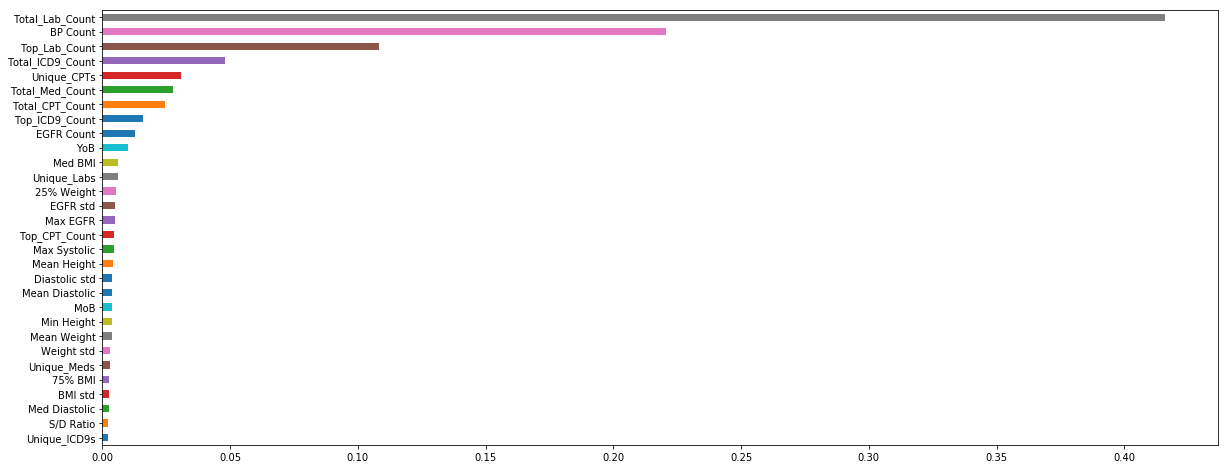

In [65]:
plt.figure(figsize=(20,8))
pd.Series(rf_cv_1.best_estimator_.feature_importances_[top30feats_1], index=X_train_1.columns[top30feats_1]).sort_values().plot.barh()

In [208]:
pred_1_rf_cv=rf_cv_1.predict(X_test_1)

In [209]:
rf_cv_1_score=rf_cv_1.score(X_test_1, y_test_1)

In [210]:
rf_cv_1_confusion=confusion_matrix(y_test_1, pred_1_rf_cv)

## Second strategy: Only coded categorical values

__Logistic regression__

Started by removing the non_categorical_columns and splitting up the data into training and testing sets, 5-fold cross-validation was more within expectations this time.

In [70]:
non_categorical_columns=['Female','Male','BMI Count','Mean BMI','BMI std','Min BMI','25% BMI','Med BMI','75% BMI','Max BMI','Mean Weight','Weight std','Min Weight',
 '25% Weight','Med Weight','75% Weight','Max Weight','Mean Height','Height std','Min Height','25% Height','Med Height','75% Height','Max Height','Pregnancy','BP Count',
 'Mean Systolic','Systolic std','Min Systolic','25% Systolic','Med Systolic','75% Systolic','Max Systolic','Mean Diastolic','Diastolic std','Min Diastolic','25% Diastolic',
 'Med Diastolic','75% Diastolic','Max Diastolic','S/D Ratio','EGFR Count','Mean EGFR','EGFR std','Min EGFR','25% EGFR','Med EGFR','75% EGFR','Max EGFR','Top_CPT_Count','Unique_CPTs',
 'Total_CPT_Count','Top_ICD9_Count','Unique_ICD9s','Total_ICD9_Count','Top_Lab_Count','Unique_Labs','Total_Lab_Count','Top_Med_Count','Unique_Meds','Total_Med_Count','DoB', 'MoB', 'YoB']

In [71]:
data_2=dataIn.drop(non_categorical_columns,axis=1)

In [72]:
X_train_2, X_test_2, y_train_2, y_test_2 = model_selection.train_test_split(data_2, readmit, test_size=0.2, random_state=0)

In [73]:
logreg_2 = LogisticRegression(solver='lbfgs',max_iter=20000,n_jobs=8)

In [74]:
scores_log_reg_2 = model_selection.cross_val_score(logreg_2, X_train_2, y_train_2, cv=5)
scores_log_reg_2

array([0.67708333, 0.65885417, 0.66883963, 0.68839635, 0.65840939])

In [75]:
logreg_2.fit(X_train_2,y_train_2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=20000, multi_class='warn',
          n_jobs=8, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [76]:
pred_2_log=logreg_2.predict(X_test_2)

In [125]:
logreg_2_score=logreg_2.score(X_test_2, y_test_2)

In [126]:
logreg_2_confusion=confusion_matrix(y_test_2, pred_2_log)

__Support Vector Classifier__

Slow and poor performance with an SVC, even after using GridSearchCV to find more optimal hyperparameters.

In [167]:
svc_rbf_2 = svm.SVC(kernel='rbf', gamma=10,random_state=42)
svc_rbf_2.fit(X_train_2,y_train_2)
svc_rbf_2.score(X_test_2,y_test_2)

0.5708333333333333

In [168]:
svc_rbf_2_scores = model_selection.cross_val_score(svc_rbf_2, X_train_2, y_train_2, cv=5)
svc_rbf_2_scores

array([0.58072917, 0.57291667, 0.59452412, 0.61147327, 0.59191656])

In [169]:
gamma = [0.001,0.01,1,10]

svc_parameter_grid_2 = {'gamma': gamma}

In [170]:
svc_rbf_cv_2=GridSearchCV(estimator=svc_rbf_2, param_grid=svc_parameter_grid_2, n_jobs=8, verbose=3, cv=5)
svc_rbf_cv_2.fit(X_train_2, y_train_2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  26 out of  30 | elapsed: 10.0min remaining:  1.5min
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed: 10.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'gamma': [0.001, 0.01, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [173]:
svc_rbf_cv_2.best_params_

{'gamma': 1}

In [174]:
pred_2_svc_rbf_cv=svc_rbf_cv_2.predict(X_test_2)

In [197]:
svc_rbf_cv_2_score=svc_rbf_cv_2.score(X_test_2, y_test_2)

In [198]:
svc_rbf_cv_2_confusion=confusion_matrix(y_test_2, pred_2_svc_rbf_cv)

In [199]:
svc_rbf_cv_2_score

0.6291666666666667

In [178]:
rf_cv_2_confusion

array([[475,  49],
       [307, 129]])

__Random Forest Classifier__

Went right into GridSearchCV due to the number of hyperparameters to optimize, then visualized the top 30 classifiers.

In [80]:
n_estimators = [1,2,3,4,5,6]
max_depth = [1,2,3,4,5,6]
max_features = [5,10,15,20,25]

parameter_grid_2 = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features}

In [81]:
rf_2 = RandomForestClassifier(n_jobs=8, criterion='entropy',random_state=42) #default criterion
rf_cv_2 = GridSearchCV(estimator=rf_2, param_grid=parameter_grid_2, n_jobs=8, verbose=3, cv=5,)
rf_cv_2.fit(X_train_2, y_train_2)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   15.7s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:   28.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   44.5s
[Parallel(n_jobs=8)]: Done 900 out of 900 | elapsed:   51.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=8,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6], 'max_depth': [1, 2, 3, 4, 5, 6], 'max_features': [5, 10, 15, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [82]:
rf_cv_2.best_params_

{'max_depth': 5, 'max_features': 20, 'n_estimators': 3}

In [83]:
top30feats_2=np.argsort(rf_cv_2.best_estimator_.feature_importances_)[::-1][0:30]

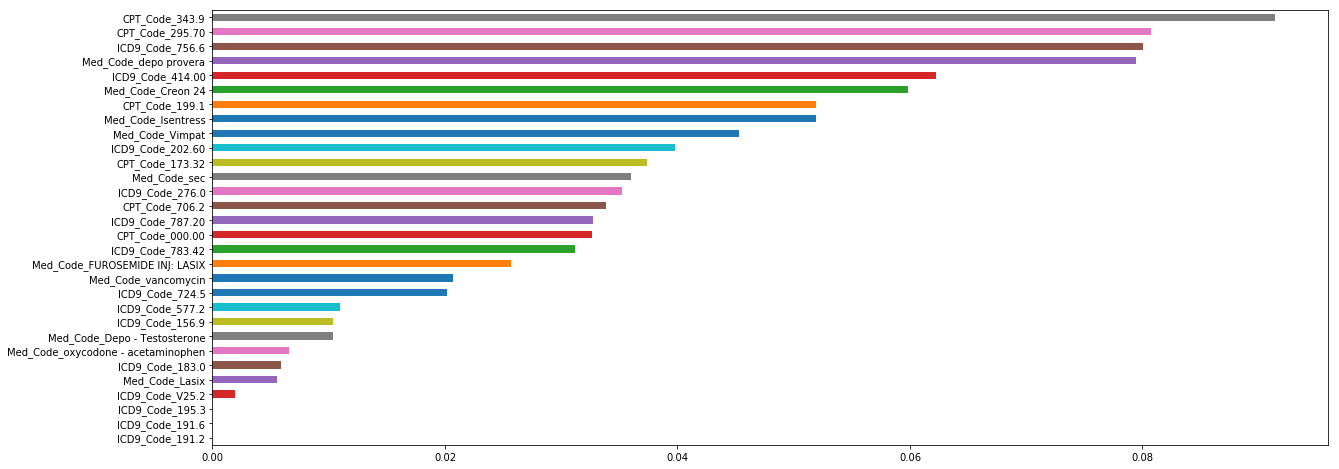

In [84]:
plt.figure(figsize=(20,8))
pd.Series(rf_cv_2.best_estimator_.feature_importances_[top30feats_2], index=X_train_2.columns[top30feats_2]).sort_values().plot.barh()

In [211]:
pred_2_rf_cv=rf_cv_2.predict(X_test_2)

In [212]:
rf_cv_2_score=rf_cv_2.score(X_test_2, y_test_2)

In [213]:
rf_cv_2_confusion=confusion_matrix(y_test_2, pred_2_rf_cv)

## Third strategy: Full dataset

__Logistic regression__

Started by removing the non_categorical_columns and splitting up the data into training and testing sets, 5-fold cross-validation showed decent performance given the increased number and mixture of dimensions.

In [88]:
dataIn.head()

,Female,Male,BMI Count,Mean BMI,BMI std,Min BMI,25% BMI,Med BMI,75% BMI,Max BMI,...,Med_Code_zofran,Med_Code_zoloft,Med_Code_zolpidem,Med_Code_zometa,Med_Code_zonisamide,Med_Code_zyprexa,Med_Code_zyrtec,DoB,MoB,YoB
RUID,,,,,,,,,,,,,,,,,,,,,
50135262,0.0,0.0,0.938776,1.709327,1.566829,1.470357,-0.276394,1.766532,1.778802,1.729090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.266667,0.333333,-0.342857
50135361,-1.0,1.0,2.346939,0.475002,0.978970,0.902344,-1.081851,0.261269,0.567844,0.585739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.066667,-0.833333,-0.828571
50135369,-1.0,1.0,1.795918,-0.050978,-0.286544,-0.320446,-0.454330,-0.004588,-0.033794,-0.066864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.800000,-0.333333,-0.085714
50135375,-1.0,1.0,3.306122,-0.007740,0.102938,0.055887,0.088968,-0.073144,0.010241,-0.019245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,-0.333333,-0.514286
50135425,0.0,0.0,1.428571,0.633938,1.221556,1.136740,0.661922,0.485560,0.518177,0.600049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.933333,0.500000,-0.428571


In [90]:
X_train_3, X_test_3, y_train_3, y_test_3 = model_selection.train_test_split(dataIn, readmit, test_size=0.2, random_state=0)

In [91]:
logreg_3 = LogisticRegression(solver='lbfgs',max_iter=20000,n_jobs=8)

In [93]:
scores_log_reg_3 = model_selection.cross_val_score(logreg_3, X_train_3, y_train_3, cv=5)
scores_log_reg_3

array([0.74348958, 0.75260417, 0.74054759, 0.75488918, 0.73142112])

In [94]:
logreg_3.fit(X_train_3,y_train_3)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=20000, multi_class='warn',
          n_jobs=8, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [95]:
pred_3_log=logreg_3.predict(X_test_3)

In [129]:
logreg_3_score=logreg_3.score(X_test_3, y_test_3)

In [130]:
logreg_3_confusion=confusion_matrix(y_test_3, pred_3_log)

__Support Vector Classifier__

Slow and poor performance with an SVC, even after using GridSearchCV to find more optimal hyperparameters, similar to data partitioning strategy 2.

In [179]:
svc_rbf_3 = svm.SVC(kernel='rbf', gamma=10,random_state=42)
svc_rbf_3.fit(X_train_3,y_train_3)
svc_rbf_3.score(X_test_3,y_test_3)

0.5458333333333333

In [180]:
svc_rbf_3_scores = model_selection.cross_val_score(svc_rbf_3, X_train_3, y_train_3, cv=5,n_jobs=8)
svc_rbf_3_scores

array([0.56380208, 0.56380208, 0.56323338, 0.56323338, 0.56323338])

In [181]:
gamma = [0.001,0.01,1,10]

svc_parameter_grid_3 = {'gamma': gamma}

In [182]:
svc_rbf_cv_3=GridSearchCV(estimator=svc_rbf_3, param_grid=svc_parameter_grid_3, n_jobs=8, verbose=3, cv=5)
svc_rbf_cv_3.fit(X_train_3, y_train_3)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 out of  20 | elapsed:  4.7min remaining:  3.1min
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:  6.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'gamma': [0.001, 0.01, 1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=3)

In [183]:
svc_rbf_cv_3.best_params_

{'gamma': 0.01}

In [203]:
pred_3_svc_rbf_cv=svc_rbf_cv_3.predict(X_test_3)

In [204]:
svc_rbf_cv_3_score=svc_rbf_cv_3.score(X_test_3, y_test_3)

In [205]:
svc_rbf_cv_3_confusion=confusion_matrix(y_test_3, pred_3_svc_rbf_cv)

In [206]:
svc_rbf_cv_3_score

0.7614583333333333

In [207]:
svc_rbf_cv_3_confusion

array([[453,  71],
       [158, 278]])

__Random Forest Classifier__

Went right into GridSearchCV due to the number of hyperparameters to optimize, then visualized the top 30 classifiers. Performance was about the same if not better than data partitioning strategy 1.

In [111]:
n_estimators = [10,11,12,13,14,15]
max_depth = [6,7,8,9,10]
max_features = [10,15,20,25,30]

parameter_grid_3 = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features}

In [112]:
rf_3 = RandomForestClassifier(n_jobs=8, criterion='entropy',random_state=42) #default criterion
rf_cv_3 = GridSearchCV(estimator=rf_3, param_grid=parameter_grid_3, n_jobs=8, verbose=3, cv=5,)
rf_cv_3.fit(X_train_3, y_train_3)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   17.0s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:   30.4s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:   45.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=8,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'n_estimators': [10, 11, 12, 13, 14, 15], 'max_depth': [6, 7, 8, 9, 10], 'max_features': [10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [113]:
rf_cv_3.best_params_

{'max_depth': 9, 'max_features': 20, 'n_estimators': 13}

In [238]:
top30feats_3=np.argsort(rf_cv_3.best_estimator_.feature_importances_)[::-1][0:30]

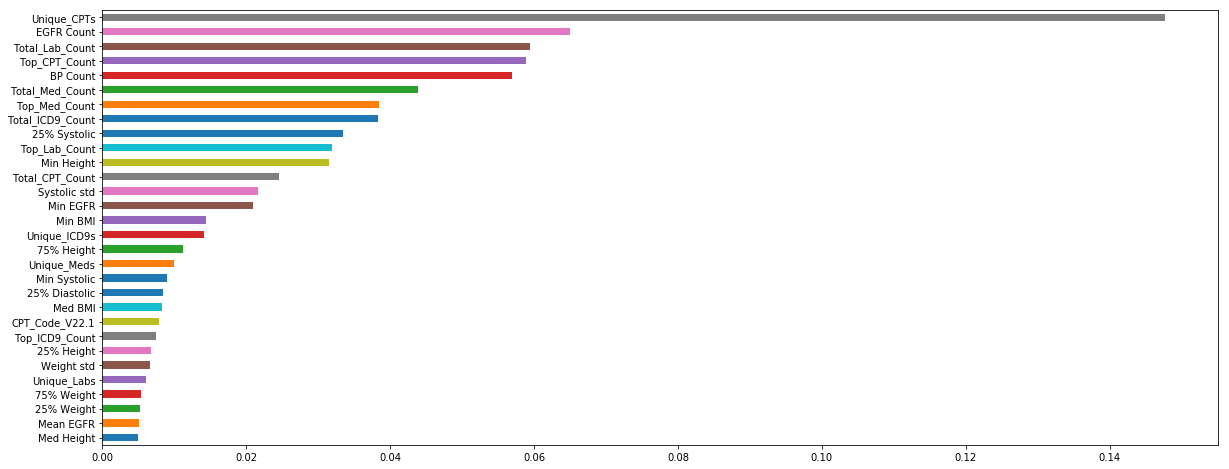

In [239]:
plt.figure(figsize=(20,8))
pd.Series(rf_cv_3.best_estimator_.feature_importances_[top30feats_3], index=X_train_3.columns[top30feats_3]).sort_values().plot.barh()

In [214]:
pred_3_rf_cv=rf_cv_3.predict(X_test_3)

In [215]:
rf_cv_3_score=rf_cv_3.score(X_test_3, y_test_3)

In [216]:
rf_cv_3_confusion=confusion_matrix(y_test_3, pred_3_rf_cv)

## Conclusion

In [217]:
accuracy_scores=pd.DataFrame([[logreg_1_score,logreg_2_score,logreg_3_score],[svc_rbf_cv_1_score,svc_rbf_cv_2_score,svc_rbf_cv_3_score],[rf_cv_1_score,rf_cv_2_score,rf_cv_3_score]])

In [236]:
accuracy_scores.columns=['Partition Strategy 1','Partition Strategy 2','Partition Strategy 3']
accuracy_scores.index=['Logistic Regression CV','RBF SVC GridsearchCV','Random Forest GridsearchCV']

In [237]:
accuracy_scores

,Partition Strategy 1,Partition Strategy 2,Partition Strategy 3
Logistic Regression CV,0.770833,0.658333,0.751042
RBF SVC GridsearchCV,0.760417,0.629167,0.761458
Random Forest GridsearchCV,0.780208,0.547917,0.768750


These are the results for the 9 combinations of strategies that I attempted. It seems that my hypothesis regarding Partition Strategy 2 was likely false, across all three modeling strategies, predictions were the most inaccurate with the inclusion of only the encoded categorical features (CPT, ICD9, etc). Interestingly, datasets that went into model training that had included the continuous variable features (BMI, BP, etc.) seemed to perform fairly well, even with the additional inclusion of the encoded categorical features. Although RBF SVC GridsearchCV had similar marginal performance with the other modeling strategies, the training and optimization time was a times worse. In the end, I would likely stick to using Logistic Regression or Random Forest Classifiers for their speed and accuracy. Notably, the accuracy of Partition Strategy 1 (including mostly continuous variable features), was slightly higher than Partition Strategy 3. This is likely because of the amount of sparse data and noise added to the data by including a few thousand more sparse features that had to encode categorical features. The most important features, as we can see in the feature_importance barplots, for Partition Strategy 3 remain primarily the continuous variable features (many of which overlap with Partition Strategy 1). This raises the importance of features to be used during the training of a model and how different training methods perform differently with different types of features.

In [227]:
top10feats_1=np.argsort(rf_cv_1.best_estimator_.feature_importances_)[::-1][0:10]
top10feats_2=np.argsort(rf_cv_2.best_estimator_.feature_importances_)[::-1][0:10]
top10feats_3=np.argsort(rf_cv_3.best_estimator_.feature_importances_)[::-1][0:10]

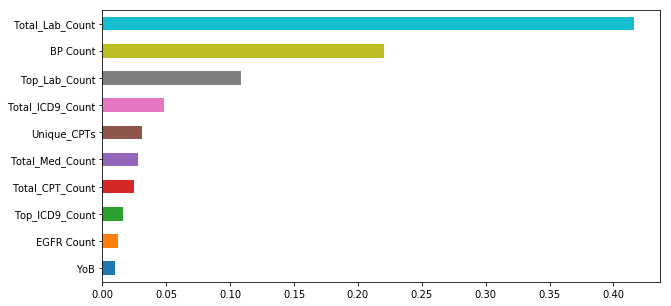

In [231]:
plt.figure(figsize=(10,5))
pd.Series(rf_cv_1.best_estimator_.feature_importances_[top10feats_1], index=X_train_1.columns[top10feats_1]).sort_values().plot.barh()

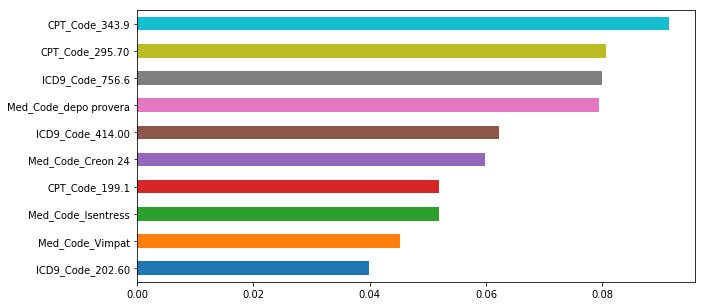

In [232]:
plt.figure(figsize=(10,5))
pd.Series(rf_cv_2.best_estimator_.feature_importances_[top10feats_2], index=X_train_2.columns[top10feats_2]).sort_values().plot.barh()

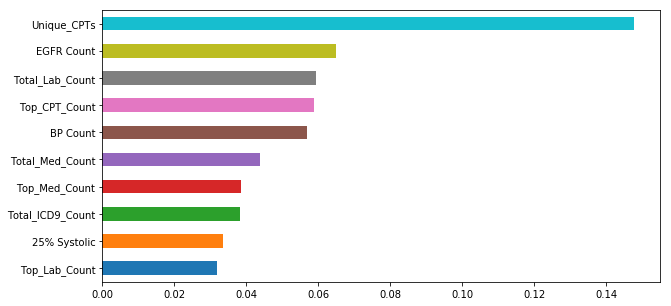

In [233]:
plt.figure(figsize=(10,5))
pd.Series(rf_cv_3.best_estimator_.feature_importances_[top10feats_3], index=X_train_3.columns[top10feats_3]).sort_values().plot.barh()

## Future directions and retrospective

Again, my goal with these strategies was to train a model that could predict, if given some features, whether or not a patient has experienced a readmission event within 30 days of being discharged. Given the combinations of partitioning strategies and training methods, __I observed a high of 0.78 accuracy with an optimized Random Forest Classifier with a subset of the features of the entire dataset.__

However, this is all relative primarily to how I chose to encode the target variable: A set of booleans simply indicating whether or not a patient, in their entire available medical record, has experience any instance of being readmitted within 30 days of being discharged. This, in retrospect, is extremely limiting in predictive power. In essence, it likely cannot be used to predict future instances of readmission within 30 days. __All my trained models can only predict is wether or not, given some features, a patient has ever experienced a readmission event.__ 

Ways that I would improve these models is to incorporate the in depth analysis of time windows just before readmission events, something not included in the final target variable (though I did record 30 day readmission dates in my preprocessing steps). With this information, I would be able build predictive models for windows of time into the future. Date information was also included in the datasets containing mostly categorical data, so reasonably, this time window incorporated model could be implemented. In addition, with respect to this consideration of time, the rate of change or frequency of continuous values over time could have been useful to incorporate, but I collapsed most of these values into single, descriptive statistics.

Finally, I dropped a significant amount of rich MED and LAB data due to their heterogeneity. The change of these values over time could likely have been informative.